In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from utils.common_transformers import NullPct, OutlierDetector, IsNull, DTypeTransformer

from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import altair as alt
from altair import Chart,X,Y

alt.data_transformers.disable_max_rows()

from sklearn.base import TransformerMixin,BaseEstimator

from utils.common import *
from utils.common_transformers import ColumnSelector,ColumnNameApplyer, OutlierImputer


from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder

# Remove Duplicates

In [2]:
df = pd.read_csv("../data/data.csv")

In [3]:
duplicated = df[df.duplicated()]
df.drop(duplicated.index,inplace=True)

display(duplicated)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [4]:
head(df)

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22,38,26,35,35
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


In [5]:
display_dtypes(df,num_rows_per_column=5)

DTypes


,0
PassengerId,int64
Survived,int64
Pclass,int64
Name,object
Sex,object
,0
Age,float64
SibSp,int64
Parch,int64
Ticket,object


In [15]:
mapping = DTypeTransformer.get_mapping_from_map_of_lists(
    bools=["Survived"],
    cats=["Pclass","Sex","Parch","SibSp","Embarked"],
)

In [17]:
df = DTypeTransformer(mapping).fit_transform(df)

In [18]:
num_cols = list(df.select_dtypes(include=np.number).columns)
num_cols = subtract_two_lists(num_cols,["PassengerId"])

In [19]:
num_cols

['Age', 'Fare']

# Outliers

In [20]:
df = OutlierDetector().fit_transform(df)

In [21]:
cols = [i for i in df.columns if i.endswith("_is_outlier")]
cols = [i for i in cols if max(df[i])]
cols += [i[:-11] for i in cols]
outlier_cols = [i for i in cols if i.endswith("_is_outlier")]

In [22]:
outlier_cols

['Age_is_outlier', 'SibSp_is_outlier', 'Parch_is_outlier', 'Fare_is_outlier']

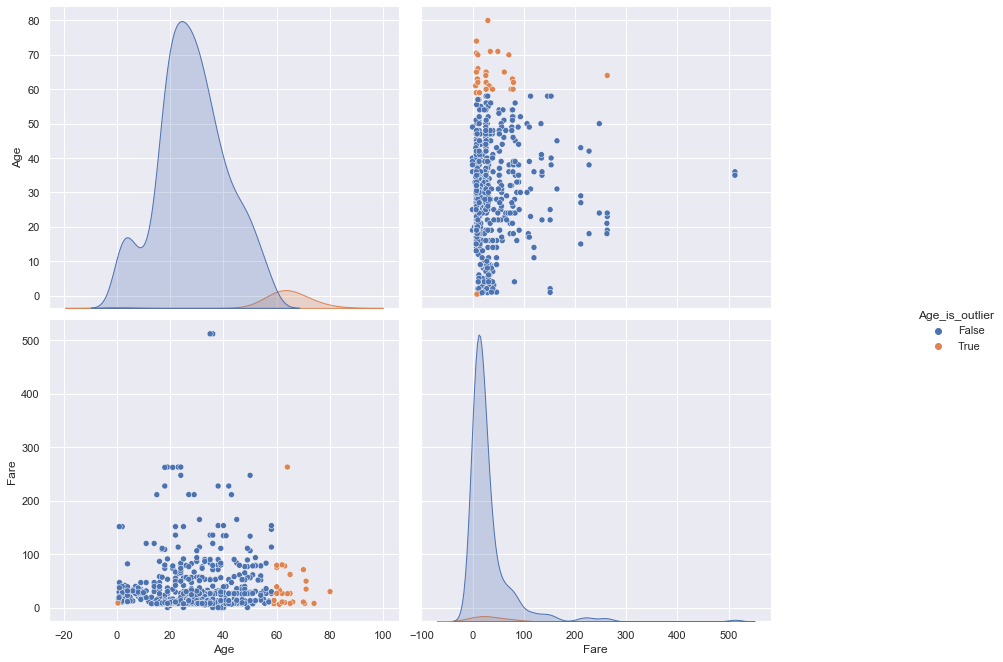

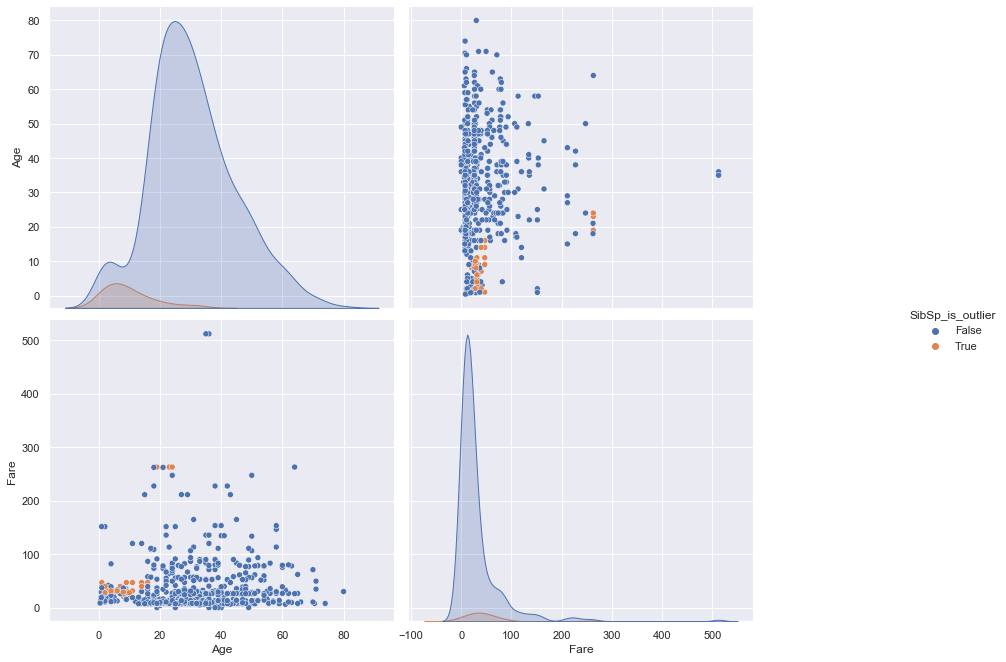

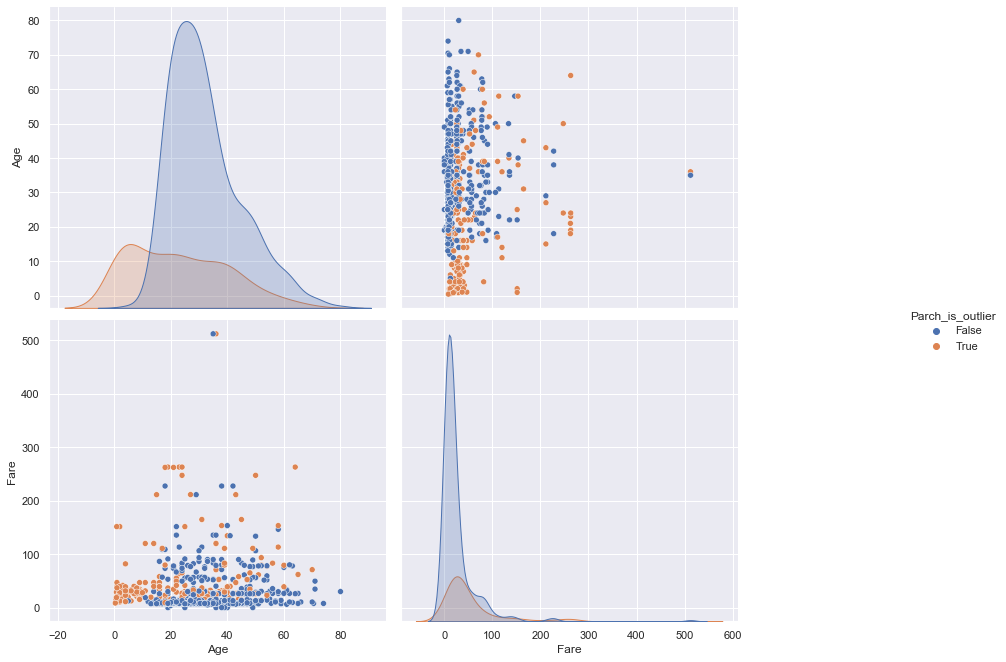

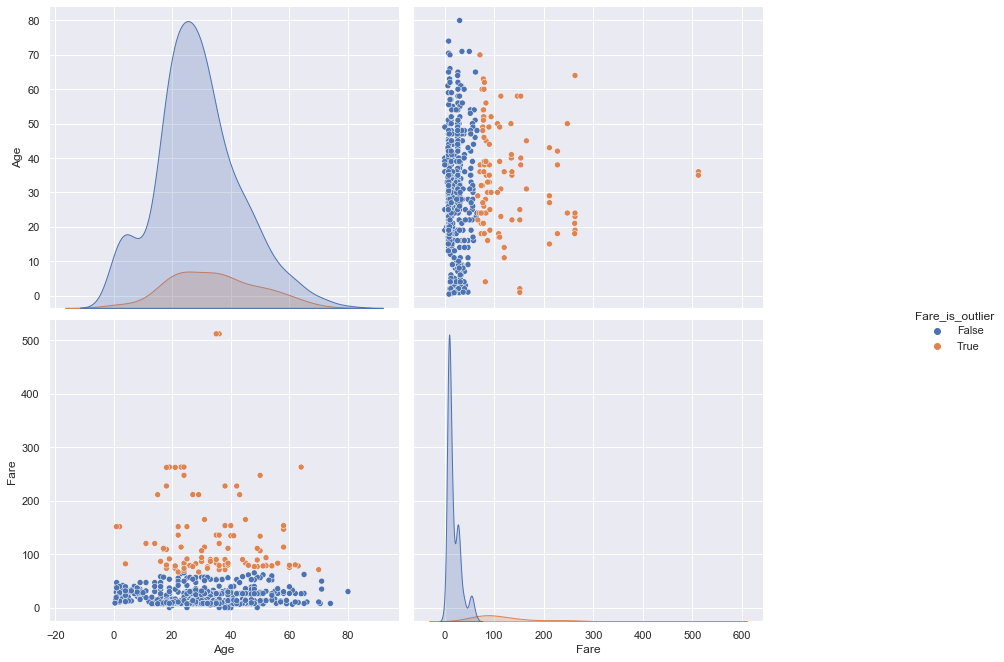

In [24]:
for col in outlier_cols:
    sns.set()
    try:
        g=sns.pairplot(df,hue=col,vars=num_cols,diag_kind="kde")
    except Exception:
        g=sns.pairplot(df,hue=col,vars=num_cols,diag_kind="hist")
    finally:
        g.fig.set_size_inches(15,10)

In [26]:
show_category_summary(df,outlier_cols,"Survived","cat")

,Count %,% Survived
Age_is_outlier,,
False,0.967452,0.387471
True,0.032548,0.275862
,Count %,% Survived
SibSp_is_outlier,,
False,0.948373,0.396450
True,0.051627,0.152174
,Count %,% Survived
Parch_is_outlier,,
False,0.760943,0.343658


# Handling Outliers

In [27]:
df["Age"].median(),df["Fare"].median()

(28.0, 14.4542)

In [28]:
display_side_by_side([pd.DataFrame(df[i].value_counts()) for i in ["Parch","SibSp"]])

,Parch
0,678
1,118
2,80
5,5
3,5
4,4
6,1
,SibSp
0,608
1,209


In [29]:
df = OutlierImputer({"Age":28,"Fare":14.46}).fit_transform(df)

# Null Analysis

In [30]:
print(list(df.columns))

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'PassengerId_is_outlier', 'Survived_is_outlier', 'Pclass_is_outlier', 'Age_is_outlier', 'SibSp_is_outlier', 'Parch_is_outlier', 'Fare_is_outlier']


In [31]:
print("Columns")
pd.DataFrame(df.isnull().mean() * 100,columns=["NullPerc"]).query("NullPerc>0").sort_values("NullPerc")

Columns


,NullPerc
Embarked,0.224467
Age,19.865320
Cabin,77.104377


In [32]:
df = NullPct().fit_transform(df)

In [33]:
Chart(df).mark_bar().encode(
    Y("null_pct:N"),
    X("count(null_pct):Q")
)

alt.Chart(...)

In [34]:
df = IsNull(exclude=["PassengerId"],drop_original_col=False).fit_transform(df)

In [35]:
num_data = df.select_dtypes(include=[int,float,bool])
var_thresh = VarianceThreshold()
var_thresh.fit(num_data)
cols_removed = [j for i,j in enumerate(list(num_data.columns)) if not var_thresh.get_support()[i]]

print("Cols Removed: ", cols_removed)

df.drop(num_data.columns,axis=1,inplace=True)
df = pd.concat([df,num_data.iloc[:,var_thresh.get_support()]],axis=1)
sample(df,n=2)

Cols Removed:  ['Pclass_is_outlier', 'Survived_is_outlier', 'PassengerId_is_outlier', 'Survived_is_null', 'Pclass_is_null', 'Name_is_null', 'Sex_is_null', 'SibSp_is_null', 'Parch_is_null', 'Ticket_is_null', 'Fare_is_null']


,391,179
Cabin,NaN,NaN
Name,"Jansson, Mr. Carl Olof","Leonard, Mr. Lionel"
Parch,0,0
Pclass,3,3
Embarked,S,S
SibSp,0,0
Sex,male,male
Ticket,350034,LINE
Survived,True,False
Parch_is_outlier,False,False


In [37]:
print("Rows With More than a single null value in a row")
df.loc[df.isnull().sum(axis=1)>=2,:].sample(n=3)

Rows With More than a single null value in a row


,Cabin,Name,Parch,Pclass,Embarked,SibSp,Sex,Ticket,Survived,Parch_is_outlier,PassengerId,Fare_is_outlier,Age,Fare,null_pct,Age_is_outlier,SibSp_is_outlier,Age_is_null,Cabin_is_null,Embarked_is_null
29,NaN,"Todoroff, Mr. Lalio",0,3,S,0,male,349216,False,False,30,False,NaN,7.8958,16.67,False,False,True,True,False
697,NaN,"Mullens, Miss. Katherine ""Katie""",0,3,Q,0,female,35852,True,False,698,False,NaN,7.7333,16.67,False,False,True,True,False
560,NaN,"Morrow, Mr. Thomas Rowan",0,3,Q,0,male,372622,False,False,561,False,NaN,7.7500,16.67,False,False,True,True,False


In [38]:
null_cols = [i for i in df.columns if i.endswith("_is_null")]

/Users/susmitvengurlekar/opt/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/susmitvengurlekar/opt/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


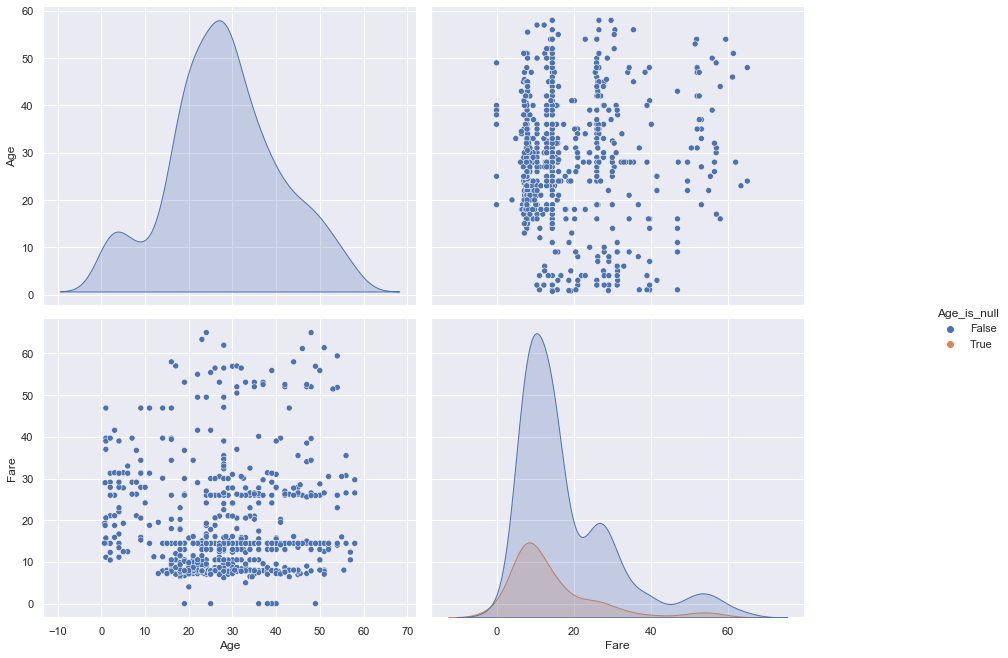

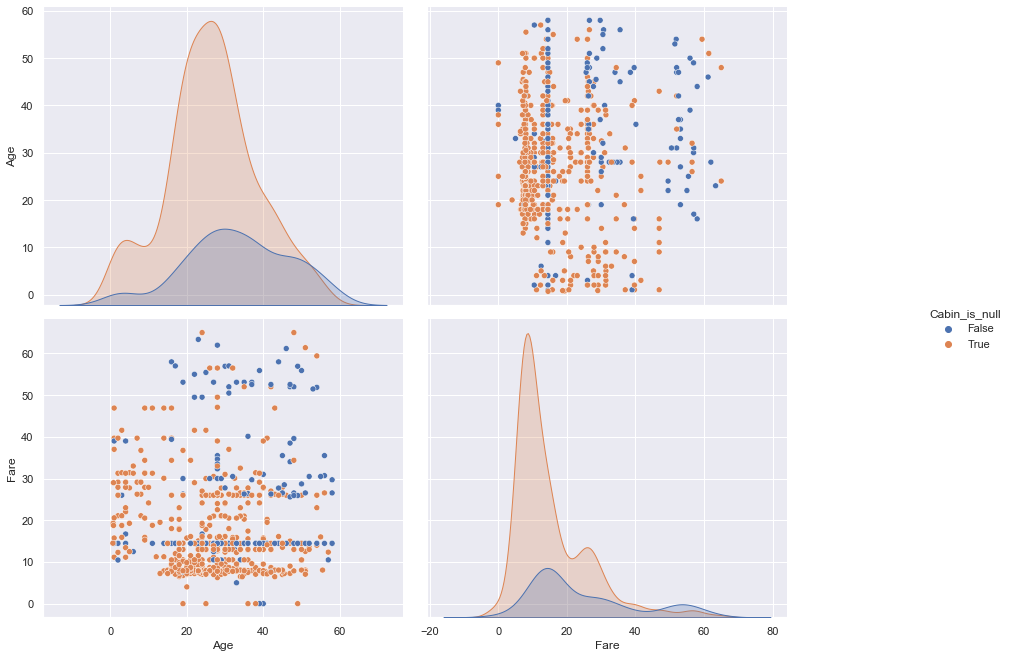

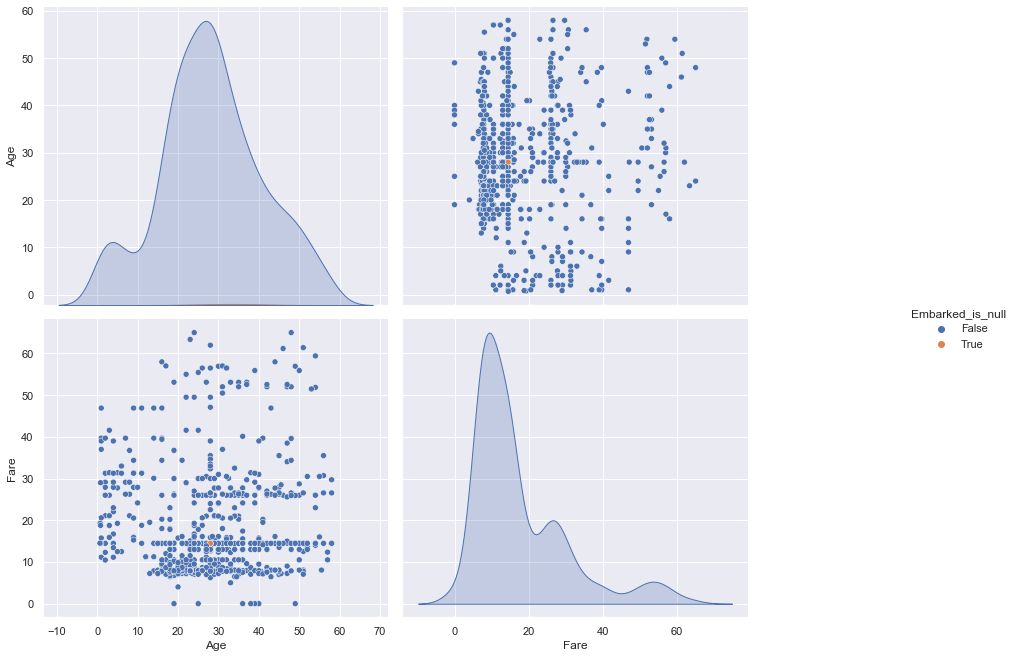

In [40]:
for col in null_cols:
    sns.set()
    try:
        g=sns.pairplot(df,hue=col,vars=num_cols,diag_kind="kde")
    except Exception:
        g=sns.pairplot(df,hue=col,vars=num_cols,diag_kind="hist")
    finally:
        g.fig.set_size_inches(15,10)

In [41]:
show_category_summary(df,null_cols,"Survived","cat")

,Count %,% Survived
Age_is_null,,
False,0.801347,0.406162
True,0.198653,0.293785
,Count %,% Survived
Cabin_is_null,,
False,0.228956,0.666667
True,0.771044,0.299854
,Count %,% Survived
Embarked_is_null,,
False,0.997755,0.382452


### Target Column Outlier (Regression Problem)

In [42]:
# df["Survived_is_outlier"].value_counts(normalize=True)*100

In [43]:
# df.query("Survived_is_outlier==True").sample(10)

# Handling Nulls

In [44]:
df.head(n=1)

,Cabin,Name,Parch,Pclass,Embarked,SibSp,Sex,Ticket,Survived,Parch_is_outlier,PassengerId,Fare_is_outlier,Age,Fare,null_pct,Age_is_outlier,SibSp_is_outlier,Age_is_null,Cabin_is_null,Embarked_is_null
0,NaN,"Braund, Mr. Owen Harris",0,3,S,1,male,A/5 21171,False,False,1,False,22.0,7.25,8.33,False,False,False,True,False


In [45]:
df = df.drop(["Cabin"],axis=1)

In [46]:
df["Embarked"] = SimpleImputer(strategy="most_frequent").fit_transform(df[["Embarked"]])

In [47]:
df["Age"] = make_pipeline(
    ColumnSelector(["Sex","Pclass","SibSp","Age"]),
    make_column_transformer(
        (OneHotEncoder(sparse=False,drop="first"),["Sex"]),
        remainder="passthrough"
    ),
    IterativeImputer(),
    ColumnNameApplyer(["Sex","Pclass","SibSp","Age"])
).fit_transform(df)["Age"]

In [48]:
df.isna().sum().max()

0

In [49]:
display_dtypes(df,num_rows_per_column=5)

DTypes


,0
Name,object
Parch,category
Pclass,category
Embarked,object
SibSp,category
,0
Sex,category
Ticket,object
Survived,bool
Parch_is_outlier,bool


## Saving dtypes info and processed data

In [50]:
cats = ["Sex","Pclass","Embarked","Parch","SibSp"]
bools = ["Parch_is_outlier","Fare_is_outlier","Age_is_outlier","SibSp_is_outlier","Survived","SibSp_is_outlier","Age_is_null","Cabin_is_null","Embarked_is_null"]


mapping = DTypeTransformer.get_mapping_from_map_of_lists(cats=cats,bools=bools)
mapping

{'Parch_is_outlier': 'bool',
 'Fare_is_outlier': 'bool',
 'Age_is_outlier': 'bool',
 'SibSp_is_outlier': 'bool',
 'Survived': 'bool',
 'Age_is_null': 'bool',
 'Cabin_is_null': 'bool',
 'Embarked_is_null': 'bool',
 'Sex': 'category',
 'Pclass': 'category',
 'Embarked': 'category',
 'Parch': 'category',
 'SibSp': 'category'}

In [51]:
import json
with open('../intermediate_data/dtypes.json', 'w') as f:
    json.dump(mapping, f)

In [39]:
df.to_csv("../intermediate_data/null_outlier_duplicates_handled.csv",index=False)